#1. Download packages
* Clone GitHub repo
* Install repo requirements
* Install technical analysis package

In [1]:
!git clone https://github.com/Pfannen/AI-Stock-Agent.git

Cloning into 'AI-Stock-Agent'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 76 (delta 18), reused 44 (delta 11), pack-reused 0
Receiving objects: 100% (76/76), 687.13 KiB | 1.08 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
%cd AI-Stock-Agent/stock_agent_reusables
!pip install -r requirements.txt
%cd ..

import stock_agent_reusables
from stock_agent_reusables.classes.StockData import StockData
from stock_agent_reusables.classes.RLModelBuilder import ModelBuilder

In [ ]:
!pip install pandas-ta

import pandas_ta as ta

## 2. Create a dataset
* Use the StockData class to get initial stock data
* Use the pandas-ta package to add technical indicators to the dataset

In [4]:
AMZNStockData = StockData(ticker="AMZN",
                          start_date="11/01/2018",
                          end_date="11/25/2023",
                          interval="1d")

In [5]:
final_df = AMZNStockData.add_indicators_to_data(indicators=[
    lambda df: (ta.sma(close=df['close'], length=15), "15_SMA"),
    lambda df: (ta.rsi(close=df['close'], length=15), "15_RSI"),
    lambda df: (ta.obv(close=df['close'], volume=df['volume']), 'OBV'),
])

final_df = final_df.drop(columns=['adjclose', 'high', 'low'])
final_df.head()

,open,close,volume,15_SMA,15_RSI,OBV
2018-11-23,75.849998,75.102997,54152000,80.884633,29.681299,-600030000.0
2018-11-26,76.949997,79.066498,125154000,80.603967,44.597338,-474876000.0
2018-11-27,78.799500,79.070999,115664000,80.449367,44.611634,-359212000.0
2018-11-28,80.695999,83.887497,169174000,80.565833,57.256619,-190038000.0
2018-11-29,83.749496,83.678497,132264000,80.292766,56.655283,-322302000.0


## 3. Set up an RL model
* Create a ModelBuilder class to set up an environment and policy optimizer and model

In [6]:
AMZNModel = ModelBuilder(df=final_df,
                        window_size=30,
                        train_percentage=0.8,
                        model_type="RecPPO",
                        policy_model="MlpLstmPolicy",
                        verbosity=1)

Using cpu device


## 4. Train the model
* Create an evaluation callback for incremental model evaluation
* Train the model for a given amount of timesteps

In [7]:
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

stop_callback = StopTrainingOnRewardThreshold(reward_threshold=1000, verbose=1)
eval_callback = EvalCallback(AMZNModel.env,
                            callback_on_new_best=stop_callback,
                            eval_freq=50000,
                            best_model_save_path="Models/AMZN",
                            verbose=1)

In [8]:
AMZNModel.train_model(timesteps=1000, callback=eval_callback)

----------------------------
| time/              |     |
|    fps             | 266 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0005496219 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance   | -0.0484      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.32         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00234     |
|    value_loss           | 2.98         |
------------------------------------------
-----------------------

## 5. Load the best model from training, or a saved model (optional)
* Sidenote: The best model saved after training is with regards to its total reward, not necessarily total profit

In [ ]:
AMZNModel.load_model("RecPPO1m.zip")

## 6. Evaluate the model
* Get a chart of the model's actions, total profit, and other performance metrics

info {'total_reward': 55.32000732421875, 'total_profit': 1.312792416229076, 'position': <Positions.Short: 0>}


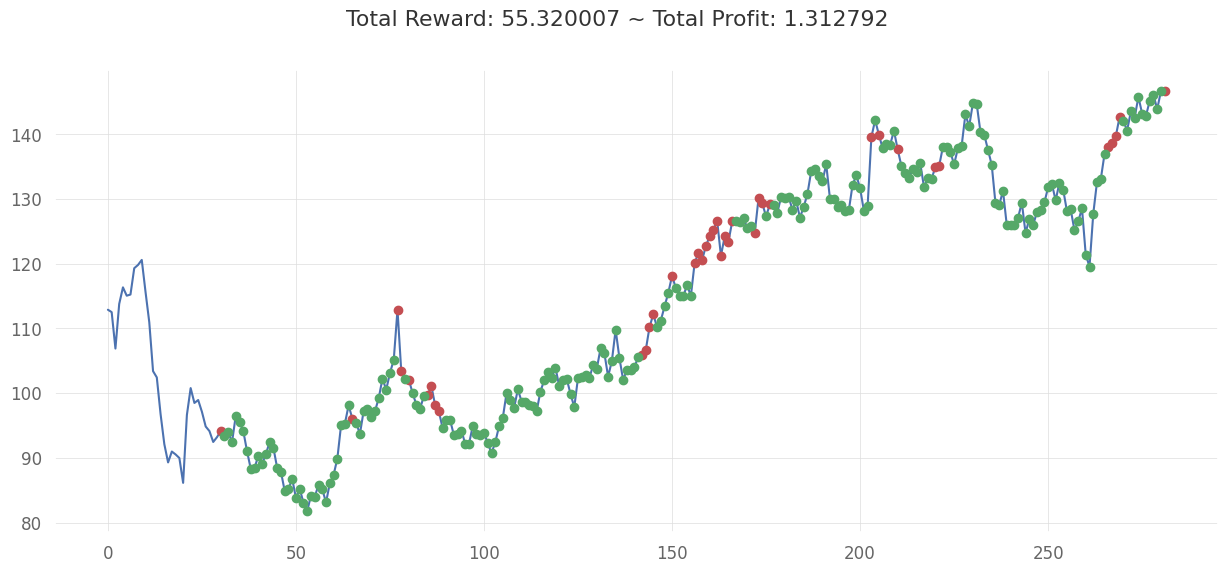

[Performance Metrics]



                           Strategy
-------------------------  ----------
Start Period               2022-11-28
End Period                 2023-11-24
Risk-Free Rate             0.0%
Time in Market             6.0%

Cumulative Return          31.28%
CAGR﹪                     20.92%

Sharpe                     1.34
Prob. Sharpe Ratio         97.86%
Smart Sharpe               1.33
Sortino                    5.31
Smart Sortino              5.27
Sortino/√2                 3.75
Smart Sortino/√2           3.73
Omega                      3.08

Max Drawdown               -7.55%
Longest DD Days            109
Volatility (ann.)          22.18%
Calmar                     2.77
Skew                       8.58
Kurtosis                   89.17

Expected Daily %           0.11%
Expected Monthly %         2.12%
Expected Yearly %          14.58%
Kelly Criterion            31.54%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.18%
Expected Shortfall (cVaR)  -2.18%

Max Consecutive Wins      

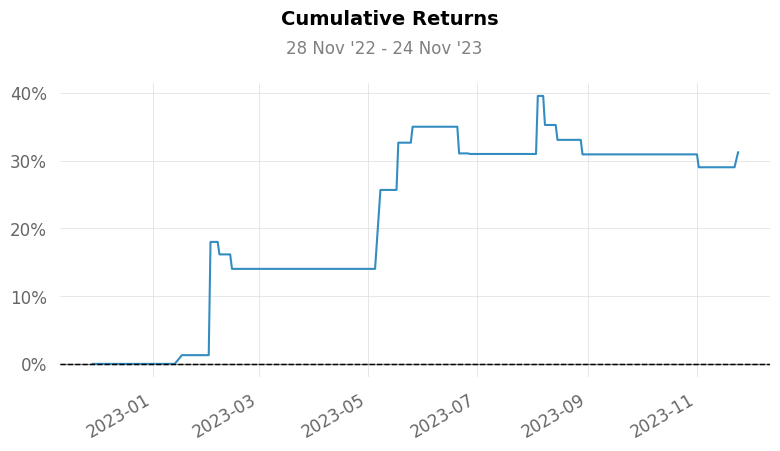

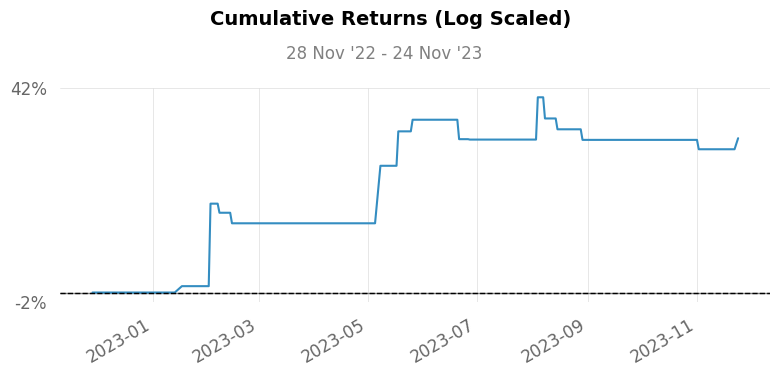

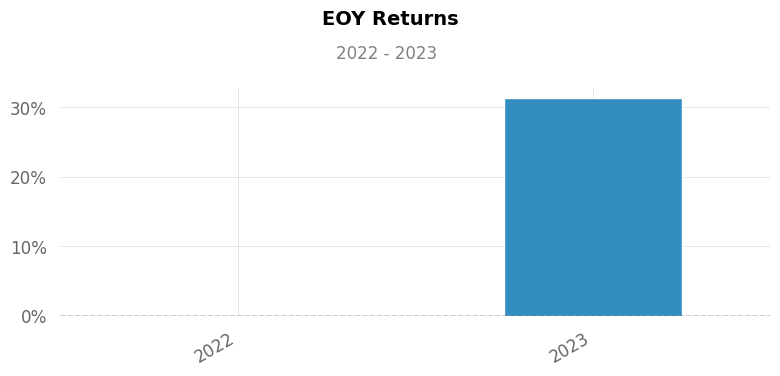

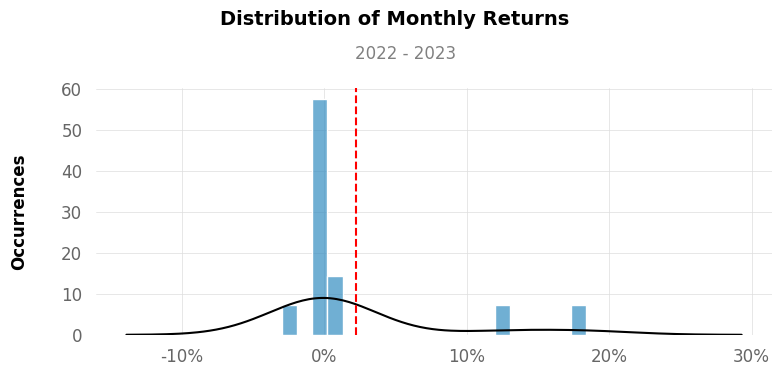

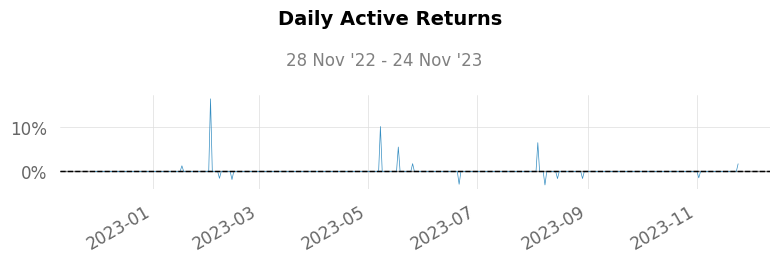

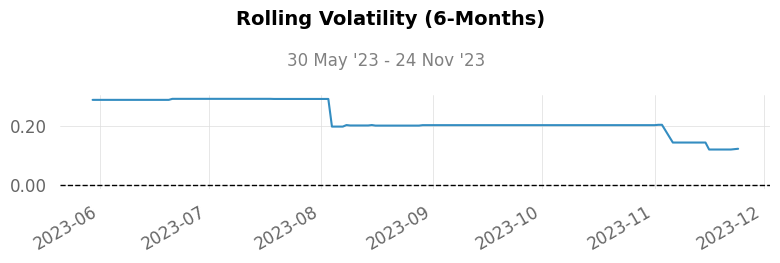

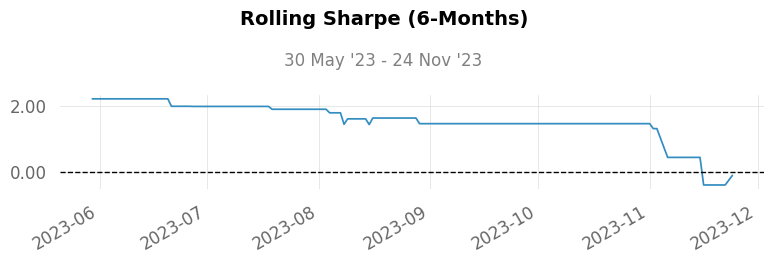

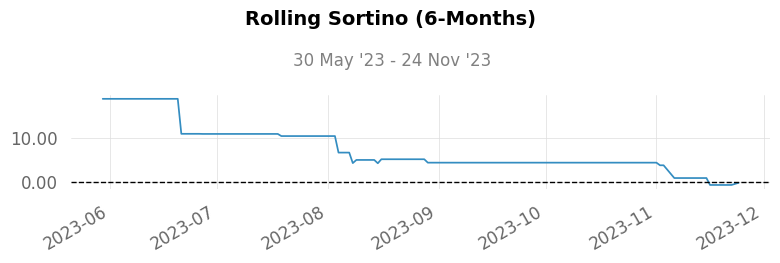

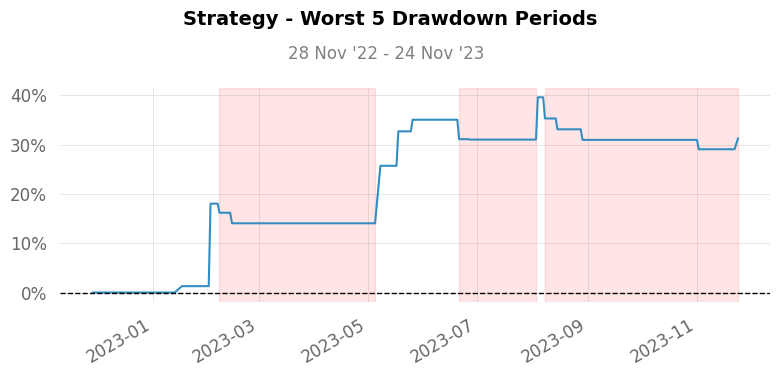

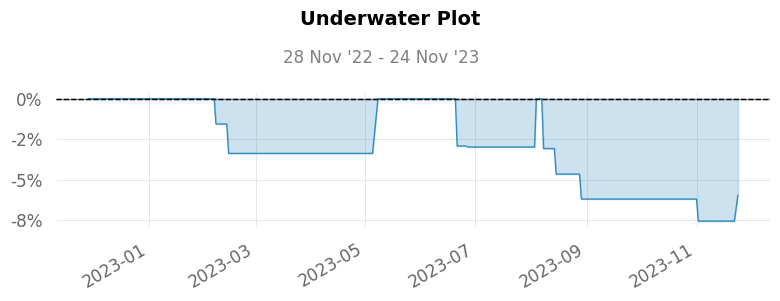

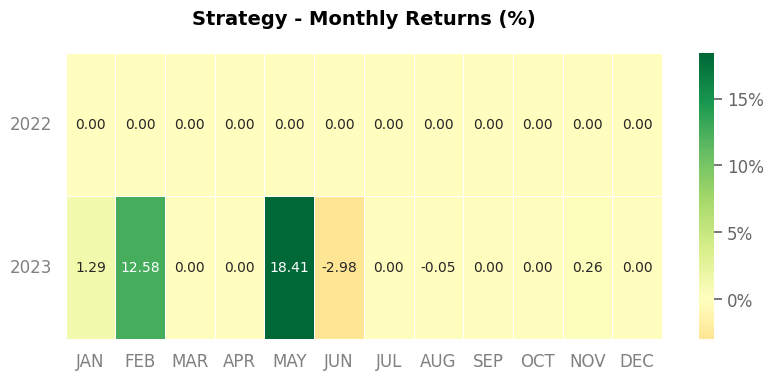

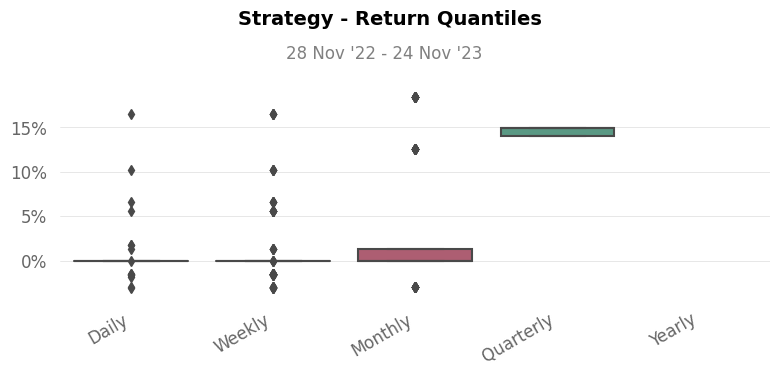

In [11]:
env = AMZNModel.get_model_report()